In [3]:
import matplotlib 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import svm

import glob
import json
import pickle
import operator
import numpy as np
import seaborn as sns
from scipy import stats
sns.set(style="ticks")
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chisquare
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from pandas.tools.plotting import parallel_coordinates
import mpl_toolkits.axes_grid1 as axes_grid1
rcParams['mathtext.default'] = 'regular'
%matplotlib inline

print('Done')

Done


In [4]:
#Load-in H-chain data

at=['H']

dat_l=[]

suffix='iao'

spins=[0]

for meth in ['uks']:
  for type in ['singles', 'doubles']:
    for k in at:
        for s in spins:
            add=pd.read_pickle("Coeff_"+np.str(k)+"_dmc_"+np.str(suffix)+"_spin"+np.str(s)+"_"+np.str(type)+"_"+meth+".pkl")
            L=len(add['energy'])
            add['Method']=[meth for k in range(L)]
            add['Excitation']=[type for k in range(L)]
            dat_l.append(add)
            
for meth in ['rks']:
  for type in ['doubles']:
    for k in at:
        for s in spins:
            add=pd.read_pickle("Coeff_"+np.str(k)+"_dmc_"+np.str(suffix)+"_spin"+np.str(s)+"_"+np.str(type)+"_"+meth+".pkl")
            L=len(add['energy'])
            add['Method']=[meth for k in range(L)]
            add['Excitation']=[type for k in range(L)]
            dat_l.append(add)
            

dat = pd.concat(dat_l)

print(dat.keys())

evc=27.2114

Len=len(dat['atom'])
dat = dat.reset_index(drop=True)

L=len(dat['energy'])

###############################################################################

dat.to_csv('H_chain_data.csv')
dat.to_pickle('H_chain_data.pkl')

act_num=10

print('Act. Pop. Cut-Off: '+np.str(act_num-0.5))
dat=dat[dat['Act. Pop.'] > act_num-0.5]
dat=dat[dat['Act. Pop.'] < act_num+0.05]
print(dat)

dat.to_csv('H_chain_data.csv')

print('')
print('Done')

Index([ u'Act. Pop.',   u'Constant',          u'J',     u'Length',
               u'Us',          u'V',         u'V2',         u'V3',
             u'atom',     u'energy',      u'error',     u'esterm',
       u'functional',       u'spin',          u't',     u'Method',
       u'Excitation'],
      dtype='object')
Act. Pop. Cut-Off: 9.5
     Act. Pop.  Constant         J Length        Us          V         V2  \
0     9.909387       1.0  1.433677    1.5  1.933368  10.668526  15.063785   
1     9.886132       1.0  0.846410    1.5  1.832331  11.577572  14.193075   
2     9.900427       1.0  0.900782    1.5  1.819653  11.700229  14.156450   
3     9.853409       1.0  0.720702    1.5  1.802538  11.445298  14.445672   
4     9.842178       1.0  0.677019    1.5  1.696226  11.720110  14.316923   
5     9.888711       1.0  0.611055    1.5  1.570895  11.104934  15.928125   
7     9.883185       1.0  0.921920    1.5  1.793921  11.353737  14.504481   
8     9.882048       1.0  0.956342    1.5  1.823

Done


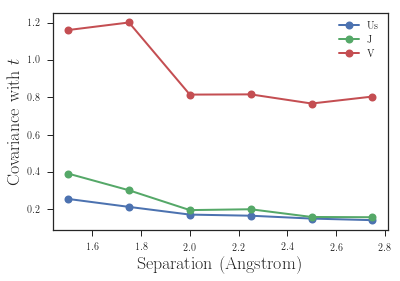

In [5]:
#Covariance of U/J/V with t as a function of Bond Length

L=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
DM_terms=['Us', 'J', 'V']

lw=0
fs=18
ms=8

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for i,p in enumerate(DM_terms):
    cov=[]
    for l in L:
        descrip=[]
        dat_L=dat[dat['Length'] == np.str(l)]
        for k in ['t',p]:
            descrip.append(dat_L[k])
        descrip_x = np.vstack(descrip)
        covt = np.cov(descrip_x)[0][1]
        cov.append(covt)
    plt.plot(L, np.abs(cov), linewidth=lw+2, marker='o', markersize=ms-2, mew=2, label=p)

plt.legend()
plt.xlabel('Separation (Angstrom)', fontsize=fs)
plt.ylabel('Covariance with $t$', fontsize=fs)
plt.savefig('t_covariance_vs_separation.pdf', bbox_inches='tight')
plt.savefig('t_covariance_vs_separation.png', bbox_inches='tight')


print('Done')

Done


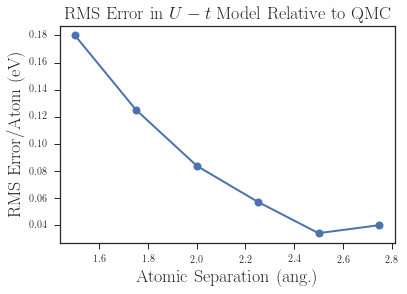

In [6]:
#Plot RMS error vs. bond length

Natom=10
from scipy.optimize import least_squares
evc=27.2114
func_choice='pbe'
#lengths=[1, 1.25, 1.5, 1.75, 2.0]
lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

def fun(parms, dum_descrip, E):
    nparm=len(parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=parms[k]*dum_descrip[l][k]
    return est-E

def mod_energy(fit_parms, dum_descrip):
    nparm=len(fit_parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=fit_parms[k]*dum_descrip[l][k]
    return est


filemod=''
parameters=['Constant', 't', 'Us']

param_hold=[[] for k in range(len(parameters)-1)]

rms_hold=[]


x0=[np.min(dat_func['energy'])]
for k in range(len(parameters)-1):
    parm_name=parameters[k+1]
    filemod+=np.str(parm_name)
    x0+=[0]

for ln in range(len(lengths)):
    plt.figure(ln)
    length=lengths[ln]
    dat_func=dat[ dat['Length']==np.str(length) ]
    descrip=np.zeros((len(dat_func['Constant']), len(parameters)))
    for i,p in enumerate(parameters):
        descrip[:,i]=np.array(dat_func[p])

    ab_energy=evc*dat_func['energy']
    ab_err=evc*dat_func['error']

    res_lin = least_squares(fun, x0, loss='linear', args=(descrip, ab_energy))
    model_energy = mod_energy(res_lin.x, descrip)
    
    resid=ab_energy-model_energy
    resid=np.array(resid)
    rms=np.sqrt(np.sum(resid**2)/len(resid))

    lw=0
    fs=18
    ms=8
        
    rms_hold.append(rms)
        
    for n in range(len(parameters)-1):
      param_hold[n].append(res_lin.x[n+1])

c=1

plt.figure(c)
c+=1
plt.plot(lengths, np.array(rms_hold)/Natom, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
plt.ylabel('RMS Error/Atom (eV)', fontsize=fs)
plt.title('RMS Error in $U-t$ Model Relative to QMC', fontsize=fs)
plt.savefig('rms_ut_error_vs_separation_h_chain.pdf', bbox_inches='tight')
plt.savefig('rms_ut_error_vs_separation_h_chain.png', bbox_inches='tight')

print('Done')

[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
[[-2.835498057947329, -2.1966273200269577, -1.7736498277028963, -1.3905472207642431, -1.0197040625101055, -0.82115083878024409], [4.6786003635162619, 8.1489509568630236, 10.050129837286063, 10.457956508527378, 11.395423244953848, 12.220012913674283]]
Done


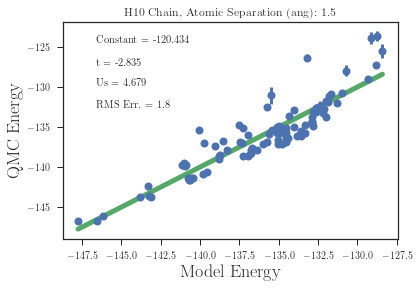

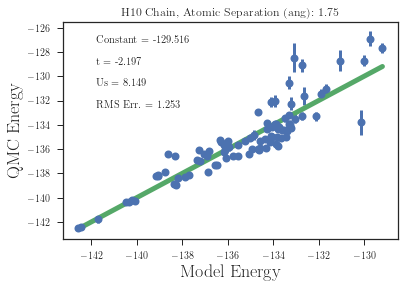

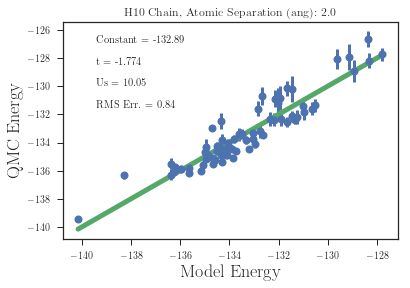

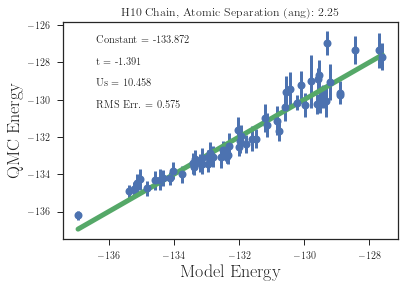

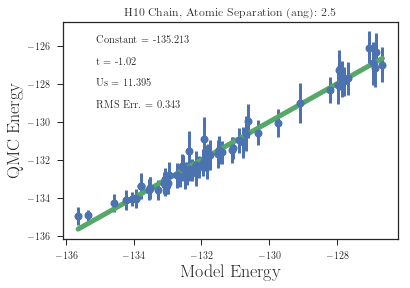

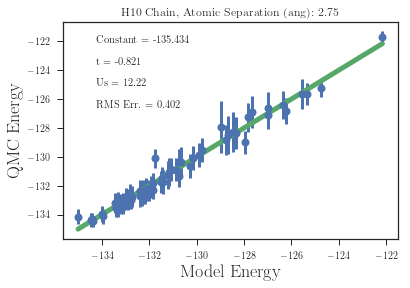

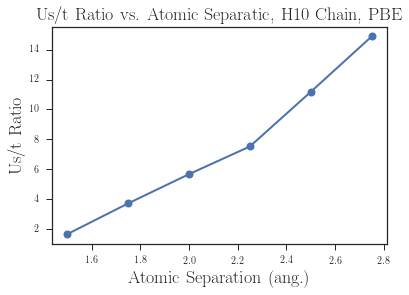

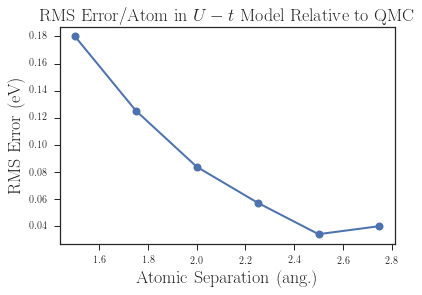

In [7]:
#Plot DMC energies vs. model energies

from scipy.optimize import least_squares
evc=27.2114
Natom=10
func_choice='pbe'
lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]


def fun(parms, dum_descrip, E):
    nparm=len(parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=parms[k]*dum_descrip[l][k]
    return est-E

def mod_energy(fit_parms, dum_descrip):
    nparm=len(fit_parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=fit_parms[k]*dum_descrip[l][k]
    return est


filemod=''
parameters=['Constant', 't', 'Us']

param_hold=[[] for k in range(len(parameters)-1)]

rms_hold=[]


x0=[np.min(dat_func['energy'])]
for k in range(len(parameters)-1):
    parm_name=parameters[k+1]
    filemod+=np.str(parm_name)
    x0+=[0]

for ln in range(len(lengths)):
    plt.figure(ln)
    length=lengths[ln]
    dat_func=dat[ dat['Length']==np.str(length) ]
    descrip=np.zeros((len(dat_func['Constant']), len(parameters)))
    for i,p in enumerate(parameters):
        descrip[:,i]=np.array(dat_func[p])

    ab_energy=evc*dat_func['energy']
    ab_err=evc*dat_func['error']

    res_lin = least_squares(fun, x0, loss='linear', args=(descrip, ab_energy))
    model_energy = mod_energy(res_lin.x, descrip)
    
    resid=ab_energy-model_energy
    resid=np.array(resid)
    rms=np.sqrt(np.sum(resid**2)/len(resid))

    lw=0
    fs=18
    ms=8

    plt.errorbar(model_energy, ab_energy, yerr=ab_err, elinewidth=3, linewidth=lw, marker='o', markersize=ms-2, mew=2)

    plt.plot([np.min(model_energy), np.max(model_energy)], [np.min(model_energy), np.max(model_energy)], linewidth=lw+5)
    plt.xlabel('Model Energy', fontsize=fs)
    plt.ylabel('QMC Energy', fontsize=fs)
    plt.title('H10 Chain, Atomic Separation (ang): '+np.str(length))

    capy=0.9
    for k in range(len(parameters)):
        par_name=np.str(parameters[k])
        plt.annotate(par_name+" = "+np.str(np.round(res_lin.x[k], 3)), xy=(0.1,capy), xycoords='axes fraction', fontsize=10.5)
        capy-=0.1
        
    plt.annotate("RMS Err. = "+np.str(np.round(rms, 3)), xy=(0.1,capy), xycoords='axes fraction', fontsize=10.5)
    rms_hold.append(rms)
        
    for n in range(len(parameters)-1):
      param_hold[n].append(res_lin.x[n+1])

    plt.savefig('H_chain_fit_model_length'+np.str(length)+'_'+np.str(filemod)+'.png', dpi=200, bbox_inches='tight')

print(lengths)
c=len(lengths)+1
print(param_hold)

if len(parameters)==3:
  plt.figure(c)
  c+=1
  plt.plot(lengths, np.abs(np.array(param_hold[1])/np.array(param_hold[0])), linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
  plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
  plt.ylabel(np.str(parameters[2])+'/'+np.str(parameters[1])+' Ratio', fontsize=fs)
  plt.title(np.str(parameters[2])+'/'+np.str(parameters[1])+' Ratio vs. Atomic Separatic, H10 Chain, PBE', fontsize=fs)
  plt.savefig(np.str(parameters[2])+np.str(parameters[1])+'_ratio_vs_separation_h_chain.png', dpi=200, bbox_inches='tight')

plt.figure(c)
c+=1
plt.plot(lengths, np.array(rms_hold)/Natom, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
plt.ylabel('RMS Error (eV)', fontsize=fs)
plt.title('RMS Error/Atom in $U-t$ Model Relative to QMC', fontsize=fs)
plt.savefig('rms_ut_error_vs_separation_h_chain.pdf', bbox_inches='tight')



print('Done')

Done


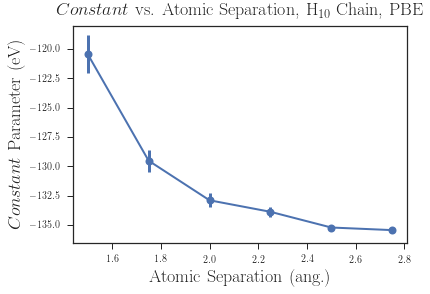

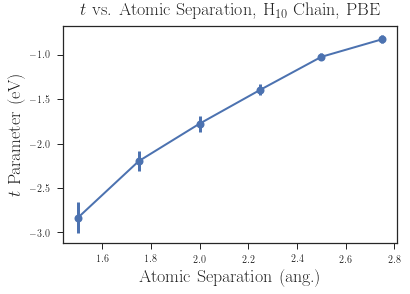

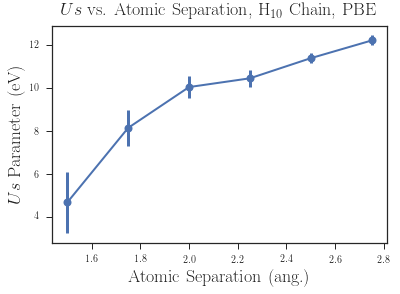

In [8]:
#Use OLS package to plot parameters vs.separation

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
evc=27.2114

def fit_dataframe(parameters,df):
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])
  x,res,rank,s=np.linalg.lstsq(A,K)
  K_mod=np.dot(A,x)
  Kerr=np.array(df['error'])
  return x,res,K,Kerr,K_mod  

def fit_dataframe_ols(parameters,df):
  evc=27.2114
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])*evc

  model=sm.OLS(K,A).fit()
  results = model  
  return model,A,K  



DM_terms=['Constant', 't', 'Us']

params={}
for p in DM_terms:
    params[p]={'Value':[], 'Error':[]}

lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

for il,l in enumerate(lengths):
    dat_L=dat_func[ dat_func['Length']==np.str(l) ]
    x=fit_dataframe(DM_terms,dat_L)
    mod,X,Y=fit_dataframe_ols(DM_terms,dat_L)
    E_ab=x[2]
    E_err=x[3]
    E_mod=x[4]
    E_err_mod=(np.array(E_ab)-np.array(E_mod))
    for iv,v in enumerate(x[0]):
        params[DM_terms[iv]]['Value'].append(v)
        params[DM_terms[iv]]['Error'].append(mod.bse[iv])
    
c=1
for i,p in enumerate(DM_terms):
      plt.figure(c)
      c+=1
      plt.errorbar(lengths, evc*np.array(params[p]['Value']), yerr=np.array(params[p]['Error']), elinewidth=3, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
      plt.xlabel('Atomic Separation (ang.)', fontsize=fs)
      plt.ylabel('$'+np.str(p)+'$ Parameter (eV)', fontsize=fs)
      plt.title('$'+np.str(p)+'$ vs. Atomic Separation, H$_{10}$ Chain, PBE', fontsize=fs)
      plt.savefig('$'+np.str(p)+'$_vs_separation_h_chain_ols.pdf', bbox_inches='tight')
      plt.savefig('$'+np.str(p)+'$_vs_separation_h_chain_ols.png', bbox_inches='tight')


print('Done')

Done


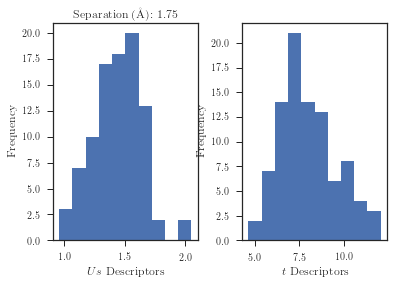

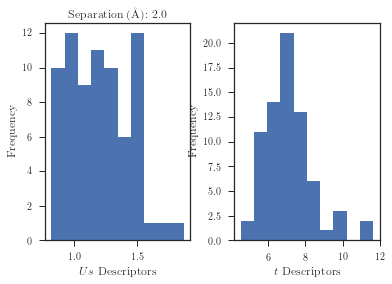

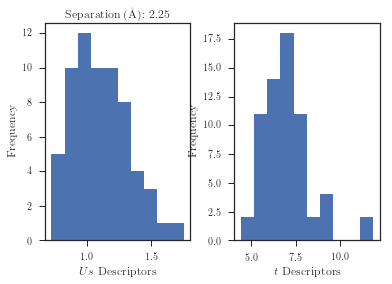

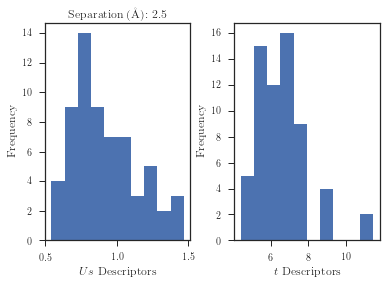

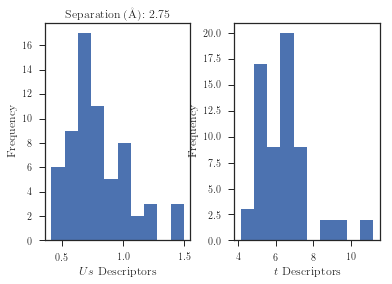

In [9]:
#Histograms of parameter distributions

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

DM_terms=['Us', 't']
functionals_list=[ 'pbe']
spins=['Spin: 0', 'Spin: 1', 'Spin: 2']
#lengths_list=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
lengths_list=[1.75, 2.0, 2.25, 2.5, 2.75]

func=functionals_list[0]

spin_choice='Spin: 0'

dat_copy=dat.copy()
dat_copy=dat_copy[dat_copy['spin']==spin_choice]

at_name=at[0]

lw=0
fs=12
ms=8
bn=10

c=1
for l in lengths_list:
    dater1=dat_copy[dat_copy['Length']==np.str(l)]
    dater1 = dater1.reset_index(drop=True)
    
    energies=dater1['energy']
    a=dater1.hist(column=DM_terms, bins=bn, grid=False)
    for i,p in enumerate(DM_terms):
      a[0][i].set_ylabel('Frequency', fontsize=fs)
      a[0][i].set_xlabel('$'+p+'$ Descriptors', fontsize=fs)
    
    a[0][0].set_title(r'Separation (\AA): '+np.str(l), fontsize=fs)
    a[0][1].set_title('', fontsize=fs)

    plt.savefig('Spin0_'+np.str(func)+'_length'+np.str(l)+'_'+np.str(at_name)+'_relation.pdf', bbox_inches='tight')
    plt.savefig('Spin0_'+np.str(func)+'_length'+np.str(l)+'_'+np.str(at_name)+'_relation.png', bbox_inches='tight')

    c+=1
    plt.figure(c)
        
print('Done')